In [2]:
import numpy as np
import pandas as pd

train_path = "X_train.csv"
label_path = "y_train.csv"
test_path = "X_test.csv"
samples_path = "samples.csv"

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
labeldf = pd.read_csv(label_path)


labels = labeldf.values
data = df.values
test_data = test_df.values

data = data[:,1:]
test_data = test_data[:,1:]
labels = labels[:,1]


print(data.shape)
print(test_data.shape)
print(labels.shape)



(5117, 17813)
(3411, 17813)
(5117,)


In [3]:
def count_instances(labels):
    unique, counts = np.unique(labels,return_counts=True)
    return dict(zip(unique,counts))

class_counts = count_instances(labels)

print("Class 0 Counts: {}".format(class_counts[0]))
print("Class 1 Counts: {}".format(class_counts[1]))
print("Class 2 Counts: {}".format(class_counts[2]))
print("Class 3 Counts: {}".format(class_counts[3]))


(num_train, max_timesteps) = data.shape
(num_test, _) = test_data.shape

Class 0 Counts: 3030
Class 1 Counts: 443
Class 2 Counts: 1474
Class 3 Counts: 170


In [4]:
# dk why I did this, might end up useful
def min_len(data):
    # faster to search column wise
    wherenan = np.isnan(data)
    for j in range(data.shape[1]):
        if np.any(wherenan[:,j]):
            return j
    """
    min_len = data.shape[1]
    for i in range(data.shape[0]):
        cond = np.isnan(data[i,:])
        if np.any(cond):
            nan_index = np.where(cond)[0][0]
            if nan_index < min_len:
                min_len = nan_index
            
    return min_len
    """
    
def fill_periodic(data):
    nanplaces = np.isnan(data)
    num_col = data.shape[1]
    for i in range(data.shape[0]):
        stop_index = np.argmax(nanplaces[i,:]==True)-1
        data[i,:] = np.resize(data[i,:stop_index],num_col)
    return data

def fill_zero(data):
    return np.nan_to_num(data)

def fft_zero_pad(data):
    zero_padded = np.nan_to_num(data)
    return np.fft.fft(zero_padded, axis=0)

# implementing below link
# https://dsp.stackexchange.com/questions/25435/dft-for-audio-classification-signals-of-different-lengths
def fft_mod_min(data):
    l = min_len(data)
    # a divisor of the column number
    split_size = data.shape[1]/379
    zero_padded = np.nan_to_num(data)
    splits = np.split(zero_padded,split_size, axis = 1)
    splits = np.array(splits)
    # caution: not sure if the order of rows gets messed up here
    # so that the labels correspond to the correct order
    splits = splits.transpose(1,0,2)
    sums = np.sum(splits, axis = 1)
    
    return np.fft.fft(sums,axis=0)

#mod_min_fft_train = fft_mod_min(data)
#zero_pad_fft_train = fft_zero_pad(data)

#mod_min_fft_test = fft_mod_min(test_data)
#zero_pad_fft_test = fft_zero_pad(test_data)

#print("Mod_min FFt shape {}".format(mod_min_fft_train.shape))
#print("Zero Padded FFt shape {}".format(zero_pad_fft_train.shape))

In [5]:
from biosppy.signals.ecg import ecg


def extract_heart(data):
    All_ts = []
    All_filtered = []
    All_rpeaks = []
    All_templates_ts = []
    All_templates = []
    All_heart_rate_ts = []
    All_heart_rate = []
    thrown_away = []
    nanplaces = np.isnan(data)
    for i in range(data.shape[0]):
        stop_index = np.argmax(nanplaces[i,:]==True) -1
        try:
            ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate = ecg(data[i,:stop_index], sampling_rate=300,show= False)
        except:
            print("Index {} was bad".format(i))
            thrown_away.append(i)
        """
        print(ts.shape)
        print(filtered.shape)
        print(rpeaks.shape)
        print(templates_ts.shape)
        print(templates.shape)
        print(heart_rate_ts.shape)
        print(heart_rate.shape)
        """
        All_ts.append(ts)
        All_filtered.append(filtered)
        All_rpeaks.append(rpeaks)
        All_templates_ts.append(templates_ts)
        All_templates.append(templates)
        All_heart_rate_ts.append(heart_rate_ts)
        All_heart_rate.append(heart_rate)
        
    return All_ts, All_filtered, All_rpeaks, All_templates_ts, All_templates, All_heart_rate_ts, All_heart_rate, thrown_away
        

ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate, thrown_away= extract_heart(data)


In [6]:
def make_numpy(heart_thing):
    
    heart_np = np.zeros((len(heart_thing),max_timesteps))
    for i in range(heart_np.shape[0]):
        nans = np.empty((1,max_timesteps-len(heart_thing[i])))
        nans[:] = np.nan
        vals = np.array(heart_thing[i]).reshape(1,len(heart_thing[i]))
        heart_np[i,:] = vals#np.concatenate((vals,nans),axis=1)
    return heart_np
"""
ts = make_numpy(ts)
filtered = make_numpy(filtered)
rpeaks = make_numpy(rpeaks)
templates_ts = make_numpy(templates_ts)
templates = make_numpy(templates)
heart_rate_ts = make_numpy(heart_rate_ts)
heart_rate = make_numpy(heart_rate)
"""



'\nts = make_numpy(ts)\nfiltered = make_numpy(filtered)\nrpeaks = make_numpy(rpeaks)\ntemplates_ts = make_numpy(templates_ts)\ntemplates = make_numpy(templates)\nheart_rate_ts = make_numpy(heart_rate_ts)\nheart_rate = make_numpy(heart_rate)\n'

In [ ]:
#ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate

from biosppy.plotting import plot_ecg


nanplaces = np.isnan(data)
y_0 = np.argwhere(labels==0)
y_1 = np.argwhere(labels==1)
y_2 = np.argwhere(labels==2)
y_3 = np.argwhere(labels==3)


ind3 = y_3[0]
ind2 = y_2[0]
ind1 = y_1[0]
ind = y_0[0]
print(ind3)
print(ind2)
print(ind1)
print(ind)
stop_index = np.argmax(nanplaces[30,:]==True) -1


ts3, filtered3, rpeaks3, templates_ts3,templates3, heart_rate_ts3, heart_rate3 = ecg(data[30,:stop_index], sampling_rate=300,show= True)




In [ ]:
stop_index = np.argmax(nanplaces[4,:]==True) -1


ts2, filtered2, rpeaks2, templates_ts2,templates2, heart_rate_ts2, heart_rate2 = ecg(data[4,:stop_index], sampling_rate=300,show= True)



In [ ]:
stop_index = np.argmax(nanplaces[3:]==True) -1


ts1, filtered1, rpeaks1, templates_ts1,templates1, heart_rate_ts1, heart_rate1 = ecg(data[3,:stop_index], sampling_rate=300,show= True)

print(ts1.shape)
print(filtered1.shape)
print(rpeaks1.shape)
print(templates_ts1.shape)
print(templates1.shape)
print(heart_rate_ts1.shape)
print(heart_rate1.shape)



In [ ]:
stop_index = np.argmax(nanplaces[0,:]==True) -1


ts0, filtered0, rpeaks0, templates_ts0,templates0, heart_rate_ts0, heart_rate0 = ecg(data[0,:stop_index], sampling_rate=300,show= True)

print(ts0.shape)
print(filtered0.shape)
print(rpeaks0)
print(templates_ts0.shape)
print(templates0.shape)
print(heart_rate_ts0.shape)
print(heart_rate0.shape)


In [ ]:
import math
def min_len(data):
    # faster to search column wise
    wherenan = np.isnan(data)
    for j in range(data.shape[1]):
        if np.any(wherenan[:,j]):
            return j
        
min_len(data)
def pad_periodic(data):
    nanplaces = np.isnan(data)
    for i in range(data.shape[0]):
        stop_index = np.argmax(nanplaces[i,:]==True) -1
        if stop_index > 0:
            rpts = math.floor(data.shape[0]/stop_index)
            print(rpts)
            data[i,:] = np.tile(data[i,:],rpts)
            #print(fill.shape)
        
        
pad_periodic(data)

In [20]:
#ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate
#what to fucking do with this shit????


In [ ]:
import math


x_folds, y_folds = make_folds(5, sxx, labels)
for i, y in enumerate(y_folds):
    print(y_folds[i].shape)
    print("Number of instances in fold {}".format(i))
    class_counts = count_instances(y_folds[i])
    print("Class 0 Counts: {}".format(class_counts[0]))
    print("Class 1 Counts: {}".format(class_counts[1]))
    print("Class 2 Counts: {}".format(class_counts[2]))
    print("Class 3 Counts: {}".format(class_counts[3]))





In [7]:
import sys
from biosppy.signals import tools as st
from biosppy.signals.ecg import correct_rpeaks, extract_heartbeats, hamilton_segmenter, ecg
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import argrelmax
from scipy.stats import stats

from scipy.stats import stats
from sklearn.metrics import f1_score
from biosppy import plotting, utils
          
    
def process_data(data, sampling_rate=300, show=False, verbose=True):
    x = []
    nanplaces = np.isnan(data)
    for i, signal in enumerate(data):
        stop_index = np.argmax(nanplaces[i,:]==True)-1
        temp = ecg(signal=signal[:stop_index],
                      sampling_rate=sampling_rate,
                      show=show
                      #segmenter=qrs_detector
                      )
        args = (data[i], temp["ts"], temp["filtered"], temp["rpeaks"],
                temp["templates_ts"], temp["templates"], temp["heart_rate_ts"],
                temp["heart_rate"])
        names = ('original', 'ts', 'filtered', 'rpeaks', 'templates_ts',
                 'templates', 'heart_rate_ts', 'heart_rate')
        temp = utils.ReturnTuple(args, names)
        x.append(temp)
        
        if verbose:
            if i % 300 == 0:
                print("Analysing sample ", i, "...Please wait...")
                sys.stdout.flush()
                
    return x

def signal_stats(signal):
    try:
        # mean, median, max, min, std, skewness, kurtosis
        # check inputs
        if signal is None:
            raise TypeError("Please specify an input signal.")

        # ensure numpy
        signal = np.array(signal)

        # mean
        mean = np.mean(signal)

        # median
        median = np.median(signal)

        # maximum amplitude abs
        maxAmpAbs = np.abs(signal - mean).max()

        # minimum amplitude abs
        minAmpAbs = np.abs(signal - mean).min()

        # maximum amplitude
        maxAmp = (signal - mean).max()

        # minimum amplitude
        minAmp = (signal - mean).min()

        # variance
        sigma2 = signal.var(ddof=1)

        # standard deviation
        sigma = signal.std(ddof=1)

        # absolute deviation
        ad = np.sum(np.abs(signal - median))

        # kurtosis
        kurt = stats.kurtosis(signal, bias=False)

        # skweness
        skew = stats.skew(signal, bias=False)
        
        # SNR
        snr = stats.signaltonoise(signal)
            
        # Entropy
        entropy = stats.entropy(signal)
        
        # Z-score
        
        zscore = stats.zscore(signal)
        
        # 3rd 4th, Moment
        
        mom3 = stats.moment(signal,3)
        mom4 = stats.moment(signal,4)
        
        # output
        args = (mean, median, maxAmpAbs, minAmpAbs, maxAmp, minAmp, sigma2,
                sigma, ad, kurt, skew )#, snr, entropy zscore, mom3, mom4)
        names = ('mean', 'median', 'maxabs', 'minabs', 'max', 'min', 'var',
                 'std_dev', 'abs_dev', 'kurtosis', 'skewness')#,"snr", "entropy")#"zscore","mom3","mom4")

        return utils.ReturnTuple(args, names)
    except Exception:
        args = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)#,0,0)#,0,0,0)
        names = ('mean', 'median', 'maxabs', 'minabs', 'max', 'min', 'var',
                 'std_dev', 'abs_dev', 'kurtosis', 'skewness')#,"snr", "entropy")#"zscore","mom3","mom4")

        return utils.ReturnTuple(args, names)
    
def RRIntervals(qrs_indices, sampling_rate=300):
    RR = np.diff(qrs_indices) / sampling_rate
    return RR

def extract_data(biooutput, sampling_rate=300):
    original_signal = biooutput["original"]
    filtered_signal = biooutput["filtered"]
    median_template = np.median(biooutput["templates"], axis=0)
    # plt.plot(median_template)
    mean_template = np.mean(biooutput["templates"], axis=0)
    std_template = np.std(biooutput["templates"], axis=0)

    # plt.plot(std_template)
    # plt.show()
    if len(median_template) == 0:
        median_template = np.zeros((0.6 * sampling_rate))
        mean_template = np.zeros((0.6 * sampling_rate))
        std_template = np.zeros((0.6 * sampling_rate))

    if len(biooutput["heart_rate"]) == 0:
        heart_rate = [0]
    else:
        heart_rate = biooutput["heart_rate"]

    if len(biooutput["rpeaks"]) == 0:
        rpeaks = [0]
    else:
        rpeaks = biooutput["rpeaks"]

    median_template_stats = signal_stats(median_template)
    mean_template_stats = signal_stats(mean_template)
    heartrate_stats = signal_stats(heart_rate)

    peak_values = original_signal[rpeaks]
    peak_stats = signal_stats(peak_values)

    rrintervals = RRIntervals(rpeaks)
    rrinterval_stats = signal_stats(rrintervals)

    median_temp_perc = np.percentile(median_template,
                                     [5, 15, 25, 35, 65, 75, 85, 95])
    mean_temp_perc = np.percentile(mean_template,
                                   [5, 15, 25, 35, 65, 75, 85, 95])
    heart_rate_perc = np.percentile(heart_rate,
                                    [5, 15, 25, 35, 65, 75, 85, 95])
    peak_perc = np.percentile(peak_values, [5, 15, 25, 35, 65, 75, 85, 95])

    rrinterval2 = np.diff(rrintervals)
    rrinterval2_stats = signal_stats(rrinterval2)
    """
    rr50 = np.sum(rrinterval2 > 0.05)
    rr20 = np.sum(rrinterval2 > 0.02)
    prr50 = rr50 / len(rrinterval2)
    prr20 = rr20 / len(rrinterval2)
    hrv_data = np.array([rr50, rr20, prr50, prr20])
    """
    numofpeaks = len(biooutput["rpeaks"])

    return (filtered_signal, median_template, mean_template, std_template,
            median_template_stats, mean_template_stats, heartrate_stats,
            peak_stats, rrinterval_stats, median_temp_perc, mean_temp_perc,
            heart_rate_perc, peak_perc, rrinterval2_stats,
            numofpeaks)


def featurevector(processed_signal, sampling_rate=300):
    results = extract_data(processed_signal, sampling_rate=sampling_rate)
    filtered_signal = results[0]
    median_template = results[1]
    mean_template = results[2]
    std_template = results[3]
    median_template_stats = list(results[4].as_dict().values())
    mean_template_stats = list(results[5].as_dict().values())
    heartrate_stats = list(results[6].as_dict().values())
    peak_stats = list(results[7].as_dict().values())
    rr_interval_stats = list(results[8].as_dict().values())
    median_temp_perc = results[9]
    mean_temp_perc = results[10]
    heart_rate_perc = results[11]
    peak_perc = results[12]
    rrinterval2_stats = list(results[13].as_dict().values())
    #hrv_data = results[14]
    numofpeaks = results[14]

    features = np.array([])
    features = np.append(features, median_template)
    features = np.append(features, mean_template)
    features = np.append(features, std_template)
    features = np.append(features, median_template_stats)
    features = np.append(features, mean_template_stats)
    features = np.append(features, heartrate_stats)
    features = np.append(features, peak_stats)
    features = np.append(features, rr_interval_stats)
    features = np.append(features, median_temp_perc)
    features = np.append(features, mean_temp_perc)
    features = np.append(features, heart_rate_perc)
    features = np.append(features, peak_perc)
    features = np.append(features, rrinterval2_stats)
    #features = np.append(features, hrv_data)
    features = np.append(features, numofpeaks)

    return filtered_signal, features


In [8]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [9]:
X1 = data
X2 = np.array([])
processed = process_data(X1, sampling_rate=300, show=False, verbose=True)

_, temp = featurevector(processed[0], sampling_rate=300)
new_length = len(temp)
all_features = np.empty((X1.shape[0], new_length))
for i in range(X1.shape[0]):
        filtered_signal, features = featurevector(processed[i], sampling_rate=300)
        assert all_features.shape[1] == len(features)
        all_features[i, :] = features
        #print(filtered_signal.shape)
        
        #X1[i, :] = filtered_signal

        if i % 300 == 0:
            print("Extracting features from sample", i)
            sys.stdout.flush()

X2 = X2.reshape(X1.shape[0], -1)
X2 = np.hstack((X2, all_features))

Analysing sample  0 ...Please wait...
Analysing sample  300 ...Please wait...
Analysing sample  600 ...Please wait...
Analysing sample  900 ...Please wait...
Analysing sample  1200 ...Please wait...
Analysing sample  1500 ...Please wait...
Analysing sample  1800 ...Please wait...
Analysing sample  2100 ...Please wait...
Analysing sample  2400 ...Please wait...
Analysing sample  2700 ...Please wait...
Analysing sample  3000 ...Please wait...
Analysing sample  3300 ...Please wait...
Analysing sample  3600 ...Please wait...
Analysing sample  3900 ...Please wait...
Analysing sample  4200 ...Please wait...
Analysing sample  4500 ...Please wait...
Analysing sample  4800 ...Please wait...
Analysing sample  5100 ...Please wait...
Extracting features from sample 0
Extracting features from sample 300
Extracting features from sample 600


/home/wen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/wen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Extracting features from sample 900
Extracting features from sample 1200
Extracting features from sample 1500
Extracting features from sample 1800
Extracting features from sample 2100
Extracting features from sample 2400
Extracting features from sample 2700
Extracting features from sample 3000
Extracting features from sample 3300
Extracting features from sample 3600
Extracting features from sample 3900
Extracting features from sample 4200
Extracting features from sample 4500
Extracting features from sample 4800
Extracting features from sample 5100


In [13]:
X1 = test_data
X_test = np.array([])
processed = process_data(X1, sampling_rate=300, show=False, verbose=True)

_, temp = featurevector(processed[0], sampling_rate=300)
new_length = len(temp)
all_features = np.empty((X1.shape[0], new_length))
for i in range(X1.shape[0]):
        filtered_signal, features = featurevector(processed[i], sampling_rate=300)
        assert all_features.shape[1] == len(features)
        all_features[i, :] = features
        #print(filtered_signal.shape)
        
        #X1[i, :] = filtered_signal

        if i % 300 == 0:
            print("Extracting features from sample", i)
            sys.stdout.flush()

X_test = X_test.reshape(X1.shape[0], -1)
X_test = np.hstack((X_test, all_features))

Analysing sample  0 ...Please wait...
Analysing sample  300 ...Please wait...
Analysing sample  600 ...Please wait...
Analysing sample  900 ...Please wait...
Analysing sample  1200 ...Please wait...
Analysing sample  1500 ...Please wait...
Analysing sample  1800 ...Please wait...
Analysing sample  2100 ...Please wait...
Analysing sample  2400 ...Please wait...
Analysing sample  2700 ...Please wait...
Analysing sample  3000 ...Please wait...
Analysing sample  3300 ...Please wait...
Extracting features from sample 0
Extracting features from sample 300
Extracting features from sample 600


/home/wen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Degrees of freedom <= 0 for slice


Extracting features from sample 900
Extracting features from sample 1200
Extracting features from sample 1500
Extracting features from sample 1800
Extracting features from sample 2100
Extracting features from sample 2400
Extracting features from sample 2700
Extracting features from sample 3000
Extracting features from sample 3300


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.svm import SVC


classifier = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=66, verbosity=1,
                                        objective='multi:softmax', booster='gbtree', tree_method='auto',
                                        n_jobs=-1, gpu_id=0, gamma=0, min_child_weight=1,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=6, base_score=0.5,
                                        random_state=0, missing=None)

# classifier = SVC(C=0.5, kernel='rbf', degree=3,
#                           gamma='scale',
# #                           gamma=1 / (1000 * x_train.std()),
#                  coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=500,
# #                  class_weight=
# #                           # 'balanced',
# #                           {0: ratio, 1: 0.9, 2: ratio},
#                           verbose=False, max_iter=-1, decision_function_shape='ova',
#                   random_state=None)

tuned_parameters = [{'boost__n_estimators':[20], 'boost__max_depth':[2], 'reg_lambda':[20]}]
# tuned_parameters = [{'C':[0.5,1,5,10,20,100]}]

bmc_scorer = make_scorer(f1_score, average = 'micro')

grid = GridSearchCV(classifier,  param_grid=tuned_parameters,  scoring=bmc_scorer, n_jobs=-1,cv =5, verbose=3)



In [12]:

from numpy import asarray
from numpy import savetxt
X2.shape
savetxt('extracted_features.csv', X2, delimiter=',')

In [39]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X2, labels, test_size=0.25, random_state=0, stratify=labels)


In [43]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
rus = RandomUnderSampler(random_state=0)
ros = RandomOverSampler(random_state=42)
x_train_sample, y_train_sample = rus.fit_resample(x_train, y_train)
# x_train_sample, y_train_sample = ros.fit_resample(x_train,y_train)

print(sorted(Counter(y_train_sample).items()))

[(0, 2272), (1, 2272), (2, 2272), (3, 2272)]


In [44]:

grid.fit(x_train_sample,y_train_sample)
y_pred = grid.predict(x_val)
F1 = f1_score(y_val, y_pred, average='micro')
print("FINAL VALIDATION {}".format(F1))


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:  4.4min remaining:   41.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.5min finished


FINAL VALIDATION 0.66796875


In [45]:
print(grid.best_params_)

{'C': 100}


Confusion matrix, without normalization
[[596  20 129  13]
 [ 12  73  23   3]
 [140  50 166  13]
 [ 13   2   7  20]]
Normalized confusion matrix
[[0.79 0.03 0.17 0.02]
 [0.11 0.66 0.21 0.03]
 [0.38 0.14 0.45 0.04]
 [0.31 0.05 0.17 0.48]]
Confusion matrix, without normalization
[[2006   40  217    9]
 [   5  318    9    0]
 [ 212   78  811    4]
 [   0    0    0  128]]
Normalized confusion matrix
[[0.88 0.02 0.1  0.  ]
 [0.02 0.96 0.03 0.  ]
 [0.19 0.07 0.73 0.  ]
 [0.   0.   0.   1.  ]]


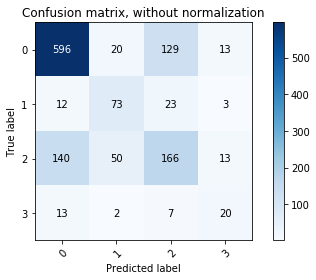

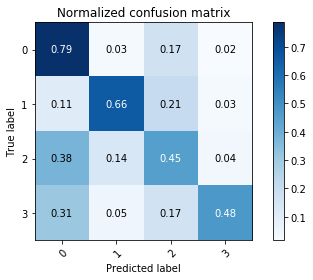

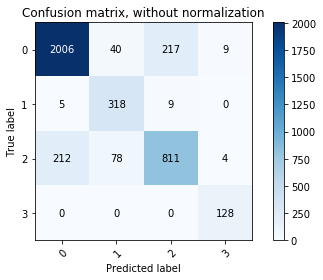

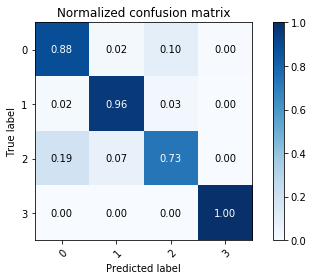

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
# y_val_pred = np.argmax(grid.predict(x_val), axis = 1)
# y_train_pred = np.argmax(grid.predict(x_train), axis = 1)
y_val_pred = grid.predict(x_val)
y_train_pred = grid.predict(x_train)


class_names = np.array([0,1,2,3])
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, y_val_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, y_val_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plot_confusion_matrix(y_train, y_train_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_train, y_train_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

In [20]:
grid.cv_results_

{'mean_fit_time': array([6.45]),
 'std_fit_time': array([0.41]),
 'mean_score_time': array([0.]),
 'std_score_time': array([0.]),
 'param_boost__max_depth': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_boost__n_estimators': masked_array(data=[20],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_reg_lambda': masked_array(data=[20],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'boost__max_depth': 2,
   'boost__n_estimators': 20,
   'reg_lambda': 20}],
 'split0_test_score': array([0.58]),
 'split1_test_score': array([0.64]),
 'split2_test_score': array([0.68]),
 'split3_test_score': array([0.67]),
 'split4_test_score': array([0.66]),
 'mean_test_score': array([0.65]),
 'std_test_score': array([0.04]),
 'rank_test_score': array([1], dtype=int32)}

In [9]:
grid.fit(X2,labels)
y_final = grid.predict(X_test)
sample = pd.read_csv("sample.csv", delimiter=',')
sample['y'] = y_final
sample.to_csv("y_pred_xgboost_featureextended.csv", index = False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  3.0min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.5min finished


In [133]:
# One vs. All for class 3
# Gave lower validation score... (sadface)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
"""
X_2_3 = X2[np.argwhere(labels==3)]
X_2_rest = X2[np.argwhere(np.logical_or((labels==1) ,(labels==2) , (labels==0)))]
labels_rest = labels[np.argwhere(np.logical_or((labels==1) ,(labels==2) , (labels==0)))]

y_onevsall = np.zeros((X2.shape[0],1))
y_onevsall[np.argwhere(labels==3)] = 0
y_onevsall[np.argwhere(np.logical_or((labels==1) ,(labels==2) , (labels==0)))] = 1
y_onevsall = y_onevsall.reshape(X2.shape[0],)
"""
svc = RandomForestClassifier(n_estimators=20, criterion='gini',
                                        max_depth=3, min_samples_split=2, min_samples_leaf=5,
                                        min_weight_fraction_leaf=0.15, max_features='auto',
                                        max_leaf_nodes=5, min_impurity_decrease=0.0,
                                        min_impurity_split=None, bootstrap=True, oob_score=False,
                                        n_jobs=-1, random_state=None, verbose=0, warm_start=False,
                                        class_weight="balanced")#SVC(C=3.0, class_weight="balanced")

classifier2 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=66, verbosity=1,
                                        tree_method='auto',
                                        n_jobs=-1, gpu_id=0, gamma=0, min_child_weight=1,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=6, base_score=0.5,
                                        random_state=0, missing=None)
ada = AdaBoostClassifier()
ova = OneVsRestClassifier(estimator=classifier2)
tuned_parameters2 = [{'estimator__n_estimators':[20], 'estimator__max_depth':[5]}]


grid2 = GridSearchCV(ova,  param_grid=tuned_parameters2,  scoring=bmc_scorer, n_jobs=-1,cv =10, verbose=3)







In [134]:
#x_train, x_val, y_train, y_val = train_test_split(X_2_rest, labels_rest, test_size=0.25, random_state=0, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(X2, labels, test_size=0.25, random_state=0, stratify=labels)


grid2.fit(x_train,y_train)

grid2.fit(x_train,y_train)
y_pred = grid2.predict(x_val)
F1 = f1_score(y_val, y_pred, average='micro')
print("FINAL VALIDATION {}".format(F1))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   44.4s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   44.6s remaining:   19.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   43.8s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   44.1s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


FINAL VALIDATION 0.81796875


In [135]:
grid2.cv_results_

{'mean_fit_time': array([39.39585977]),
 'std_fit_time': array([8.95670957]),
 'mean_score_time': array([0.03712521]),
 'std_score_time': array([0.01062188]),
 'param_estimator__max_depth': masked_array(data=[5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_estimator__n_estimators': masked_array(data=[20],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__max_depth': 5, 'estimator__n_estimators': 20}],
 'split0_test_score': array([0.81240069]),
 'split1_test_score': array([0.83302305]),
 'split2_test_score': array([0.79620908]),
 'split3_test_score': array([0.79986982]),
 'split4_test_score': array([0.77438259]),
 'split5_test_score': array([0.81969694]),
 'split6_test_score': array([0.79445275]),
 'split7_test_score': array([0.7931409]),
 'split8_test_score': array([0.82245337]),
 'split9_test_score': array([0.80397884]),
 'mean_test_score': array([0.80497268]),
 'std_test_score': array([

In [136]:
grid2.fit(X2,labels)
y_final = grid2.predict(X_test)
#y_final[np.argwhere(y_3s==3)] = 3
sample = pd.read_csv("sample.csv", delimiter=',')
sample['y'] = y_final
sample.to_csv("OneVsAll_xgboost_featureSelection.csv", index = False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   20.7s remaining:   48.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   20.7s remaining:    8.9s


KeyboardInterrupt: 